## Federated Analysis

Here we take the weights from each of the models, aggregate them and then use these with each of the studies


In [1]:
import numpy as np

def aggregate_weights_median(weights_dict):
    """
    Aggregate weights layer-wise across all studies using the median.
    """
    studies = list(weights_dict.keys())
    n_layers = len([w for w in weights_dict[studies[0]] if w is not None])

    aggregated_weights = []
    for layer_idx in range(n_layers):
        # Collect all weights for this layer across studies
        layer_weights = [weights_dict[study][layer_idx] for study in studies if weights_dict[study] is not None]

        # Stack and take median across the first axis (studies)
        stacked = np.stack(layer_weights, axis=0)
        median_weight = np.median(stacked, axis=0)
        aggregated_weights.append(median_weight)

    return aggregated_weights


In [2]:
def extract_model_weights_per_study(mse_summaries):
    weights_dict = {}

    for study in mse_summaries.keys():
        model_path = f"models/{study}_model.keras"

        try:
            model = load_model(model_path)
            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import os

def build_model_from_file(model_path):
    """
    Load a Keras model structure from an existing model file (without weights).
    """
    model = load_model(model_path)
    model_json = model.to_json()
    new_model = model_from_json(model_json)
    return new_model


In [4]:
def build_federated_model(aggregated_weights, reference_model_path):
    """
    Build a model with aggregated weights.
    """
    model = build_model_from_file(reference_model_path)
    model.set_weights(aggregated_weights)
    return model


In [5]:
from sklearn.metrics import mean_squared_error
import pandas as pd

def evaluate_federated_model(model, X_test, y_true, antibody_labels):
    """
    Evaluate reconstructed output from federated model.
    """
    reconstructed = model.predict(X_test)
    mse_per_ab = {}

    for i, ab in enumerate(antibody_labels):
        mse = mean_squared_error(y_true[:, i], reconstructed[:, i])
        mse_per_ab[ab] = mse

    mse_median = np.median(list(mse_per_ab.values()))
    mse_iqr = np.subtract(*np.percentile(list(mse_per_ab.values()), [75, 25]))

    print(f"Federated Model MSE (median): {mse_median:.4f}")
    print(f"IQR: {mse_iqr:.4f}")
    print("Per-Autoantibody MSE:")
    print(pd.Series(mse_per_ab).sort_values())

    return {
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": mse_per_ab,
        "reconstructed": reconstructed
    }


In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def evaluate_federated_model(federated_model, mse_summaries, study):
    summary = mse_summaries[study]
    
    X_test = summary["X_test"]
    antibodies = summary["antibody_labels"]
    age_groups = summary["Age_Group"]
    sex = summary["Sex"]

    # Reshape for CNN
    X_test_reshaped = X_test.reshape((-1, X_test.shape[1], 1, 1))
    
    # Predict
    reconstructed = federated_model.predict(X_test_reshaped)

    # Flatten CNN output
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # Overall MSE
    mse = mean_squared_error(X_test, reconstructed_flat)
    
    # Per-antibody MSE
    per_ab_mse = {
        ab: mean_squared_error(X_test[:, i], reconstructed_flat[:, i])
        for i, ab in enumerate(antibodies)
    }

    # Median of per-antibody MSEs
    mse_median = np.median(list(per_ab_mse.values()))
    mse_iqr = np.subtract(*np.percentile(list(per_ab_mse.values()), [75, 25]))

    # Build DataFrames (MUST use flattened arrays)
    df = pd.DataFrame(X_test, columns=antibodies)
    df["Age_Group"] = age_groups
    df["Sex"] = sex

    df_recon = pd.DataFrame(reconstructed_flat, columns=antibodies)
    df_recon["Age_Group"] = age_groups
    df_recon["Sex"] = sex

    # MSE by age group
    mse_by_age = df.groupby("Age_Group").apply(
        lambda g: mean_squared_error(
            g[antibodies], df_recon.loc[g.index, antibodies]
        )
    ).to_dict()

    # MSE by sex
    mse_by_sex = df.groupby("Sex").apply(
        lambda g: mean_squared_error(
            g[antibodies], df_recon.loc[g.index, antibodies]
        )
    ).to_dict()

    return {
        "mse": mse,
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": per_ab_mse,
        "mse_by_age_group": mse_by_age,
        "mse_by_sex": mse_by_sex,
        "N_test": len(X_test),
        "y_true": X_test,
        "y_pred": reconstructed_flat,
    }


In [7]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [8]:
import pickle

# Load mse_summaries from file
with open("data/mse_summaries.pkl", "rb") as f:
    mse_summaries = pickle.load(f)

# Confirm structure
print(mse_summaries.keys())


dict_keys(['SDY569', 'SDY1625', 'SDY524', 'SDY797', 'SDY1737'])


In [9]:
# === Run this
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]
weights_dict = extract_model_weights_per_study(mse_summaries)

In [10]:
# 1. Aggregate the weights
aggregated_weights = aggregate_weights_median(weights_dict)

# 2. Build federated model using any of the saved models as architecture reference
reference_model_path = "models/SDY569_model.keras"  # or any other
federated_model = build_federated_model(aggregated_weights, reference_model_path)



In [11]:
federated_results = {}
for study in mse_summaries:
    print(f"Evaluating federated model on {study}...")
    federated_results[study] = evaluate_federated_model(federated_model, mse_summaries, study)


Evaluating federated model on SDY569...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Evaluating federated model on SDY1625...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Evaluating federated model on SDY524...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating federated model on SDY797...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating federated model on SDY1737...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:4

from pprint import pprint
pprint(federated_results[study_list[0]])

In [12]:
comparison_data = []

for study in mse_summaries:
    local_mse = mse_summaries[study]["mse_median"]
    fed_mse = federated_results[study]["mse"]
    delta = local_mse - fed_mse
    pct_improvement = (delta / local_mse) * 100

    comparison_data.append({
        "Study": study,
        "Local MSE": round(local_mse, 4),
        "Federated MSE": round(fed_mse, 4),
        "Δ MSE": round(delta, 4),
        "% Improvement": f"{pct_improvement:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Study,Local MSE,Federated MSE,Δ MSE,% Improvement
0,SDY569,0.0013,0.0633,-0.0620,-4899.93%
1,SDY1625,0.0014,0.0331,-0.0317,-2222.47%
2,SDY524,0.0100,0.1264,-0.1165,-1169.04%
3,SDY797,0.1205,0.4075,-0.2870,-238.16%
4,SDY1737,0.0295,0.0441,-0.0147,-49.82%


## Retrain Federated Model on Each Study and Evaluate Stratified MSE

In [13]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Store results after retraining
retrain_detailed_results = {}

for study in study_list:
    print(f"\n--- Retraining Federated Model on Study: {study} ---")

    summary = mse_summaries[study]
    
    # Extract X_train and reshape only relevant features
    X_train = summary["X_train"]
    antibodies = summary["antibody_labels"]

    # Number of features used in training (including one-hot encoded Age_Group and Sex)
    n_features_used = federated_model.input_shape[1]

    # Defensive check
    if X_train.shape[1] != n_features_used:
        print(f"  ⚠ Reshaping X_train: expected {n_features_used}, got {X_train.shape[1]}")
        # Try to truncate or slice appropriately
        X_train = X_train[:, :n_features_used]

    # Reshape for CNN input
    X_train_reshaped = X_train.reshape((-1, n_features_used, 1, 1))

    # Clone the federated model and copy weights
    local_model = clone_model(federated_model)
    local_model.set_weights(federated_model.get_weights())
    local_model.compile(optimizer=Adam(), loss='mse')

    # Retrain
    local_model.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=8, verbose=1)

    # Evaluate after retraining
    results_post = evaluate_federated_model(local_model, mse_summaries, study)
    retrain_detailed_results[study] = results_post



--- Retraining Federated Model on Study: SDY569 ---
  ⚠ Reshaping X_train: expected 7, got 12
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0904
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0900
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0895
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0890
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0886
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0881
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0877
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0873
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0869
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY1625 ---
  ⚠ Reshaping X_train: expected 7, got 10
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280  
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY524 ---
  ⚠ Reshaping X_train: expected 7, got 12
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0988  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0927
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0872
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0811
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 0.0750
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0688
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0620
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0557
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.0499
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 0.0449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY797 ---
  ⚠ Reshaping X_train: expected 7, got 10
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4516  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4435
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4349
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4261
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4167
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4070
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3967
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3851
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3724
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Retraining Federated Model on Study: SDY1737 ---
  ⚠ Reshaping X_train: expected 7, got 13
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1078  
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1057
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1045
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1036
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1027
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1017
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1007
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0998
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0990
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


In [14]:
retrain_detailed_results = {}

for study in study_list:
    summary = mse_summaries[study]
    X_train = summary["X_train"]
    n_features_used = federated_model.input_shape[1]
    
    if X_train.shape[1] != n_features_used:
        X_train = X_train[:, :n_features_used]
    
    X_train_reshaped = X_train.reshape((-1, n_features_used, 1, 1))
    
    # Clone & compile model
    local_model = clone_model(federated_model)
    local_model.set_weights(federated_model.get_weights())
    local_model.compile(optimizer=Adam(), loss='mse')
    
    # Retrain
    local_model.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=8, verbose=0)
    
    # Evaluate and save
    results_post = evaluate_federated_model(local_model, mse_summaries, study)
    retrain_detailed_results[study] = results_post


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_25386/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


In [15]:
from pprint import pprint
pprint(retrain_detailed_results[study_list[0]])


{'N_test': 2,
 'mse': 0.06066677830716074,
 'mse_by_age_group': {'18-30': 0.018919855231921752,
                      '8-12': 0.10241370138239973},
 'mse_by_sex': {'Female': 0.10241370138239973, 'Male': 0.018919855231921752},
 'mse_iqr': 0.004298425569248115,
 'mse_median': 0.0029917982177763564,
 'per_antibody_mse': {'GAD65': 0.4009146994190921,
                      'IA2IC': 0.008204670539154378,
                      'ICA': 0.0029917982177763564,
                      'MIAA': 0.0020893833508708205,
                      'PAD_0': 0.005461858877841452,
                      'PAD_1': 0.002024742817761334,
                      'ZNT8': 0.0029802949276287807},
 'y_pred': array([[0.02695022, 0.12385202, 0.06026406, 0.05405573, 0.05663883,
        0.07973693, 0.04263912],
       [0.0451386 , 0.09181423, 0.06018131, 0.05533149, 0.05246554,
        0.06757025, 0.0472376 ]], dtype=float32),
 'y_true': array([[0.85849057, 0.02631579, 0.10047847, 0.        , 0.        ,
        0.        , 0.  

In [16]:
import pandas as pd

rows = []

for study in study_list:
    try:
        fed_mse = mse_summaries[study]["mse_median"]
        retrain_mse = retrain_detailed_results[study]["mse_median"]

        rows.append({
            "Study": study,
            "Federated MSE (Median)": round(fed_mse, 6),
            "Retrained MSE (Median)": round(retrain_mse, 6),
            "Δ MSE": round(retrain_mse - fed_mse, 6),
            "% Change": round(100 * (retrain_mse - fed_mse) / fed_mse, 2)
        })
    except KeyError as e:
        print(f"Missing key {e} for study {study}")

df_summary = pd.DataFrame(rows)
df_summary


,Study,Federated MSE (Median),Retrained MSE (Median),Δ MSE,% Change
0,SDY569,0.001266,0.002992,0.001726,136.40
1,SDY1625,0.001425,0.002277,0.000852,59.79
2,SDY524,0.009963,0.061604,0.051641,518.36
3,SDY797,0.120504,0.280808,0.160303,133.03
4,SDY1737,0.029467,0.005811,-0.023657,-80.28


In [17]:
import pandas as pd

rows = []

for study in study_list:
    local_mse = mse_summaries[study]["mse_median"]
    federated_mse = federated_results[study]["mse_median"]
    retrained_mse = retrain_detailed_results[study]["mse_median"]

    rows.append({
        "Study": study,
        "Local MSE": round(local_mse, 6),
        "Federated MSE": round(federated_mse, 6),
        "Retrained MSE": round(retrained_mse, 6),
        "Δ Fed - Local": round(federated_mse - local_mse, 6),
        "Δ Retrain - Local": round(retrained_mse - local_mse, 6),
    })

df_mse_comparison = pd.DataFrame(rows)
df_mse_comparison


,Study,Local MSE,Federated MSE,Retrained MSE,Δ Fed - Local,Δ Retrain - Local
0,SDY569,0.001266,0.002635,0.002992,0.001369,0.001726
1,SDY1625,0.001425,0.003054,0.002277,0.001629,0.000852
2,SDY524,0.009963,0.064978,0.061604,0.055015,0.051641
3,SDY797,0.120504,0.485538,0.280808,0.365033,0.160303
4,SDY1737,0.029467,0.004001,0.005811,-0.025466,-0.023657


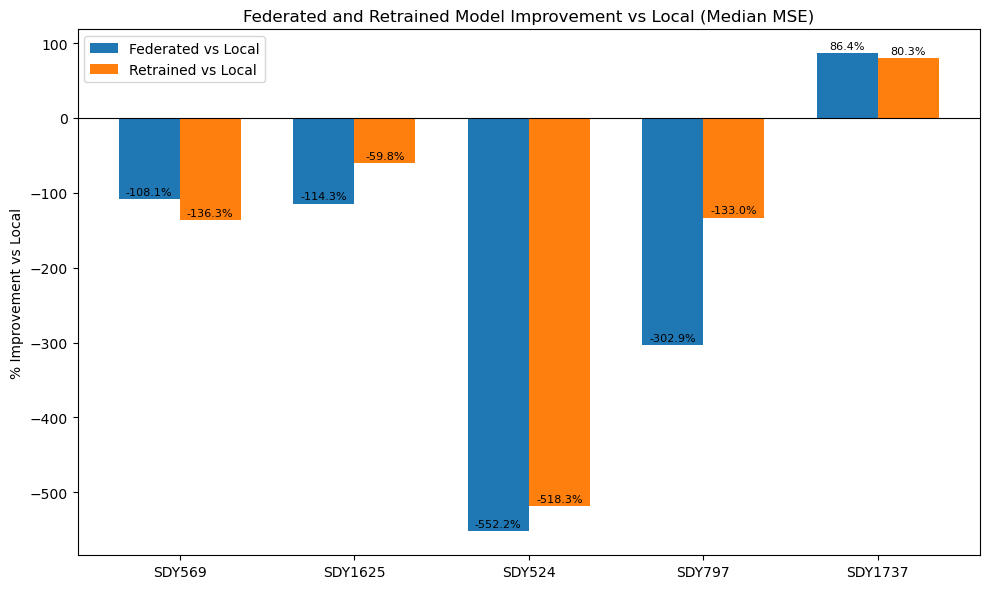

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Compute % improvement columns
df_mse_comparison["% Improvement (Federated vs Local)"] = (
    (df_mse_comparison["Local MSE"] - df_mse_comparison["Federated MSE"]) / df_mse_comparison["Local MSE"]
) * 100

df_mse_comparison["% Improvement (Retrained vs Local)"] = (
    (df_mse_comparison["Local MSE"] - df_mse_comparison["Retrained MSE"]) / df_mse_comparison["Local MSE"]
) * 100

# Set up bar plot
x = np.arange(len(df_mse_comparison["Study"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2,
               df_mse_comparison["% Improvement (Federated vs Local)"],
               width, label="Federated vs Local")

bars2 = ax.bar(x + width/2,
               df_mse_comparison["% Improvement (Retrained vs Local)"],
               width, label="Retrained vs Local")

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', fontsize=8)

# Labels and formatting
ax.set_ylabel('% Improvement vs Local')
ax.set_title('Federated and Retrained Model Improvement vs Local (Median MSE)')
ax.set_xticks(x)
ax.set_xticklabels(df_mse_comparison["Study"])
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
plt.tight_layout()
plt.show()



In [19]:
# Save final MSE summary DataFrame to CSV
df_mse_comparison.to_csv("data/mse_comparison_summary.csv", index=False)


In [20]:
mse_summaries[study]["per_antibody_mse"]


{'GAD65': 0.05160560983656589,
 'IA2IC': 0.11386117650570668,
 'MIAA': 0.05561677174044269,
 'ICA': 0.000583502803796032,
 'ZNT8': 0.029467458266974323,
 'PAD_0': 0.0021918685544731,
 'PAD_1': 0.0014130542771930987}

In [21]:
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]


In [22]:
import pandas as pd
import numpy as np



# === Per-Antibody MSE Table ===
antibody_rows = []

for study in study_list:
    local_ab = mse_summaries[study]["per_antibody_mse"]
    fed_ab = federated_results[study]["per_antibody_mse"]
    retrain_ab = retrain_detailed_results[study]["per_antibody_mse"]

    for ab in local_ab:
        local = local_ab.get(ab, np.nan)
        fed = fed_ab.get(ab, np.nan)
        retrained = retrain_ab.get(ab, np.nan)

        antibody_rows.append({
            "Study": study,
            "Antibody": ab,
            "Local MSE": local,
            "Federated MSE": fed,
            "Retrained MSE": retrained,
            "Δ Fed - Local": fed - local,
            "Δ Retrain - Local": retrained - local,
            "% Improvement (Fed vs Local)": ((local - fed) / local * 100) if local else np.nan,
            "% Improvement (Retrain vs Local)": ((local - retrained) / local * 100) if local else np.nan
        })

df_antibody_mse = pd.DataFrame(antibody_rows)

# === Sex-wise MSE (Federated) ===
sex_rows = []

for study in study_list:
    for sex, val in federated_results[study]["mse_by_sex"].items():
        sex_rows.append({
            "Study": study,
            "Sex": sex,
            "Federated MSE": val
        })

df_sex_mse = pd.DataFrame(sex_rows)

# === Age-group MSE (Federated) ===
age_rows = []

for study in study_list:
    for age, val in federated_results[study]["mse_by_age_group"].items():
        age_rows.append({
            "Study": study,
            "Age_Group": age,
            "Federated MSE": val
        })

df_age_mse = pd.DataFrame(age_rows)

# Display all
from IPython.display import display
display(df_antibody_mse)
display(df_sex_mse)
display(df_age_mse)


,Study,Antibody,Local MSE,Federated MSE,Retrained MSE,Δ Fed - Local,Δ Retrain - Local,% Improvement (Fed vs Local),% Improvement (Retrain vs Local)
0,SDY569,GAD65,0.384153,0.424172,0.400915,0.040019,0.016761,-10.417445,-4.363201
1,SDY569,IA2IC,0.000928,0.005093,0.008205,0.004165,0.007277,-448.917134,-784.264681
2,SDY569,MIAA,0.002135,0.002215,0.002089,0.000079,-0.000046,-3.721717,2.144316
3,SDY569,ICA,0.000852,0.001788,0.002992,0.000936,0.002140,-109.947838,-251.312095
4,SDY569,ZNT8,0.001242,0.002635,0.002980,0.001393,0.001739,-112.186746,-140.031908
5,SDY569,PAD_0,0.002782,0.005649,0.005462,0.002867,0.002680,-103.056136,-96.332215
6,SDY569,PAD_1,0.001266,0.001400,0.002025,0.000134,0.000759,-10.614348,-59.983829
7,SDY1625,GAD65,0.009356,0.001898,0.002399,-0.007458,-0.006957,79.713607,74.360703
8,SDY1625,IA2IC,0.138900,0.148942,0.143203,0.010042,0.004303,-7.229544,-3.097799
9,SDY1625,MIAA,0.000298,0.003055,0.001001,0.002757,0.000702,-924.841069,-235.644011


,Study,Sex,Federated MSE
0,SDY569,Female,0.106904
1,SDY569,Male,0.019653
2,SDY1625,Female,0.002155
3,SDY1625,Male,0.064049
4,SDY524,Female,0.135032
5,SDY524,Male,0.122127
6,SDY797,Female,0.266495
7,SDY797,Male,0.442749
8,SDY1737,Female,0.055042
9,SDY1737,Male,0.011465


,Study,Age_Group,Federated MSE
0,SDY569,18-30,0.019653
1,SDY569,8-12,0.106904
2,SDY1625,8-12,0.033102
3,SDY524,13-17,0.137740
4,SDY524,8-12,0.122315
5,SDY797,8-12,0.407498
6,SDY1737,13-17,0.031383
7,SDY1737,8-12,0.056913


In [23]:
import pandas as pd
import numpy as np

antibody_rows = []

for study in study_list:
    local_ab = mse_summaries[study]["per_antibody_mse"]
    fed_ab = federated_results[study]["per_antibody_mse"]
    retr_ab = retrain_detailed_results[study]["per_antibody_mse"]

    for ab in local_ab.keys():
        local = local_ab.get(ab, np.nan)
        fed = fed_ab.get(ab, np.nan)
        retr = retr_ab.get(ab, np.nan)

        antibody_rows.append({
            "Study": study,
            "Antibody": ab,
            "Local MSE (median)": local,
            "Federated MSE (median)": fed,
            "Retrained MSE (median)": retr,
            "Δ Fed − Local": fed - local,
            "Δ Retrain − Local": retr - local,
            "% Improvement Fed vs Local": ((local - fed) / local * 100) if local > 0 else np.nan,
            "% Improvement Retrain vs Local": ((local - retr) / local * 100) if local > 0 else np.nan,
        })

df_antibody_mse = pd.DataFrame(antibody_rows)


In [24]:
from sklearn.metrics import mean_squared_error

sex_rows = []

for study in study_list:
    summary = mse_summaries[study]

    X_true = summary["X_test"]
    X_recon_local = summary["reconstructed"]
    sex_labels = summary["Sex"]

    for sex in np.unique(sex_labels):
        idx = sex_labels == sex

        # Local (median of squared error)
        local_mse = np.median((X_true[idx] - X_recon_local[idx]) ** 2)

        # Federated (already computed)
        fed_mse = federated_results[study]["mse_by_sex"].get(sex, np.nan)

        # Retrained (already computed)
        retr_mse = retrain_detailed_results[study]["mse_by_sex"].get(sex, np.nan)

        sex_rows.append({
            "Study": study,
            "Sex": sex,
            "Local MSE (median)": local_mse,
            "Federated MSE (median)": fed_mse,
            "Retrained MSE (median)": retr_mse,
            "Δ Fed − Local": fed_mse - local_mse,
            "Δ Retrain − Local": retr_mse - local_mse,
        })

df_sex_mse = pd.DataFrame(sex_rows)


In [25]:
age_rows = []

for study in study_list:
    summary = mse_summaries[study]

    X_true = summary["X_test"]
    X_recon_local = summary["reconstructed"]
    age_labels = summary["Age_Group"]

    for age in np.unique(age_labels):
        idx = age_labels == age

        # Local
        local_mse = np.median((X_true[idx] - X_recon_local[idx]) ** 2)

        # Federated
        fed_mse = federated_results[study]["mse_by_age_group"].get(age, np.nan)

        # Retrained
        retr_mse = retrain_detailed_results[study]["mse_by_age_group"].get(age, np.nan)

        age_rows.append({
            "Study": study,
            "Age_Group": age,
            "Local MSE (median)": local_mse,
            "Federated MSE (median)": fed_mse,
            "Retrained MSE (median)": retr_mse,
            "Δ Fed − Local": fed_mse - local_mse,
            "Δ Retrain − Local": retr_mse - local_mse,
        })

df_age_mse = pd.DataFrame(age_rows)


In [26]:
from IPython.display import display

display(df_antibody_mse)
display(df_sex_mse)
display(df_age_mse)

df_antibody_mse.to_csv("data/per_antibody_mse_median.csv", index=False)
df_sex_mse.to_csv("data/per_sex_mse_median.csv", index=False)
df_age_mse.to_csv("data/per_age_group_mse_median.csv", index=False)


,Study,Antibody,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local,% Improvement Fed vs Local,% Improvement Retrain vs Local
0,SDY569,GAD65,0.384153,0.424172,0.400915,0.040019,0.016761,-10.417445,-4.363201
1,SDY569,IA2IC,0.000928,0.005093,0.008205,0.004165,0.007277,-448.917134,-784.264681
2,SDY569,MIAA,0.002135,0.002215,0.002089,0.000079,-0.000046,-3.721717,2.144316
3,SDY569,ICA,0.000852,0.001788,0.002992,0.000936,0.002140,-109.947838,-251.312095
4,SDY569,ZNT8,0.001242,0.002635,0.002980,0.001393,0.001739,-112.186746,-140.031908
5,SDY569,PAD_0,0.002782,0.005649,0.005462,0.002867,0.002680,-103.056136,-96.332215
6,SDY569,PAD_1,0.001266,0.001400,0.002025,0.000134,0.000759,-10.614348,-59.983829
7,SDY1625,GAD65,0.009356,0.001898,0.002399,-0.007458,-0.006957,79.713607,74.360703
8,SDY1625,IA2IC,0.138900,0.148942,0.143203,0.010042,0.004303,-7.229544,-3.097799
9,SDY1625,MIAA,0.000298,0.003055,0.001001,0.002757,0.000702,-924.841069,-235.644011


,Study,Sex,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local
0,SDY569,Female,0.001202,0.106904,0.102414,0.105702,0.101211
1,SDY569,Male,0.001380,0.019653,0.018920,0.018273,0.017540
2,SDY1625,Female,0.000829,0.002155,0.001853,0.001327,0.001025
3,SDY1625,Male,0.002169,0.064049,0.060168,0.061880,0.057998
4,SDY524,Female,0.002389,0.135032,0.060173,0.132643,0.057784
5,SDY524,Male,0.001268,0.122127,0.048638,0.120859,0.047370
6,SDY797,Female,0.066540,0.266495,0.224422,0.199955,0.157883
7,SDY797,Male,0.038838,0.442749,0.351106,0.403910,0.312268
8,SDY1737,Female,0.020828,0.055042,0.050411,0.034214,0.029582
9,SDY1737,Male,0.002951,0.011465,0.011204,0.008513,0.008253


,Study,Age_Group,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local
0,SDY569,18-30,0.001380,0.019653,0.018920,0.018273,0.017540
1,SDY569,8-12,0.001202,0.106904,0.102414,0.105702,0.101211
2,SDY1625,8-12,0.000850,0.033102,0.031010,0.032252,0.030161
3,SDY524,13-17,0.004049,0.137740,0.056580,0.133691,0.052531
4,SDY524,8-12,0.001120,0.122315,0.050993,0.121196,0.049874
5,SDY797,8-12,0.040422,0.407498,0.325769,0.367076,0.285347
6,SDY1737,13-17,0.010246,0.031383,0.029184,0.021137,0.018938
7,SDY1737,8-12,0.023990,0.056913,0.052034,0.032923,0.028044


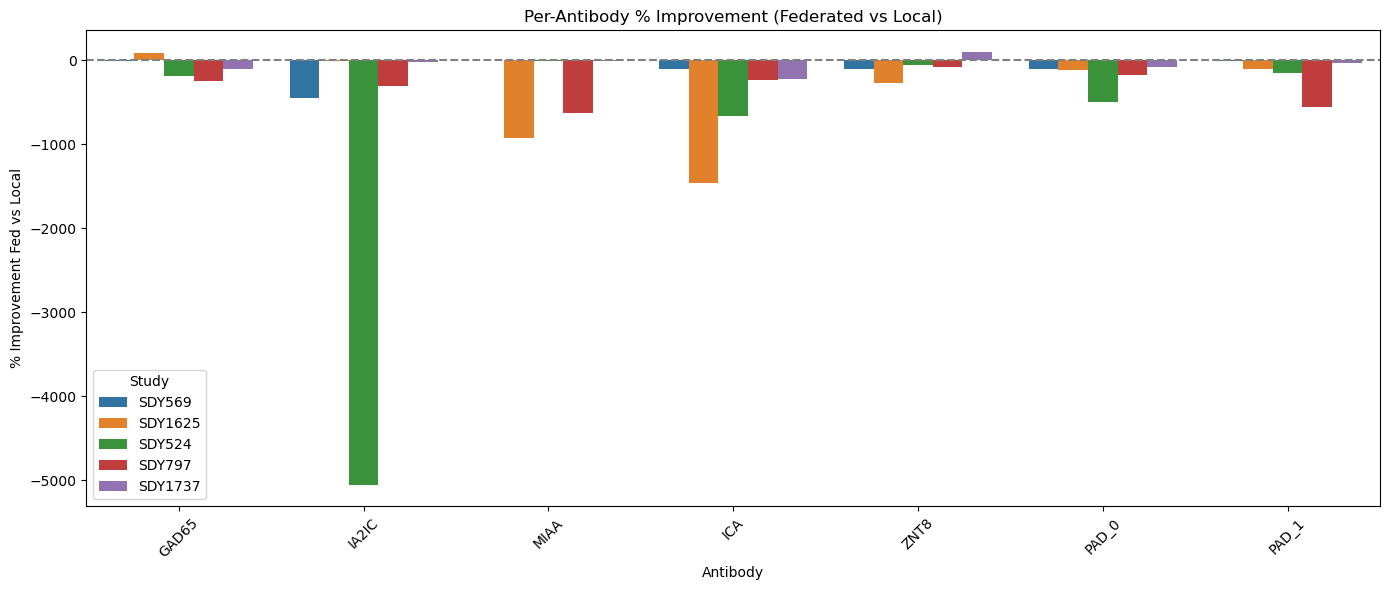

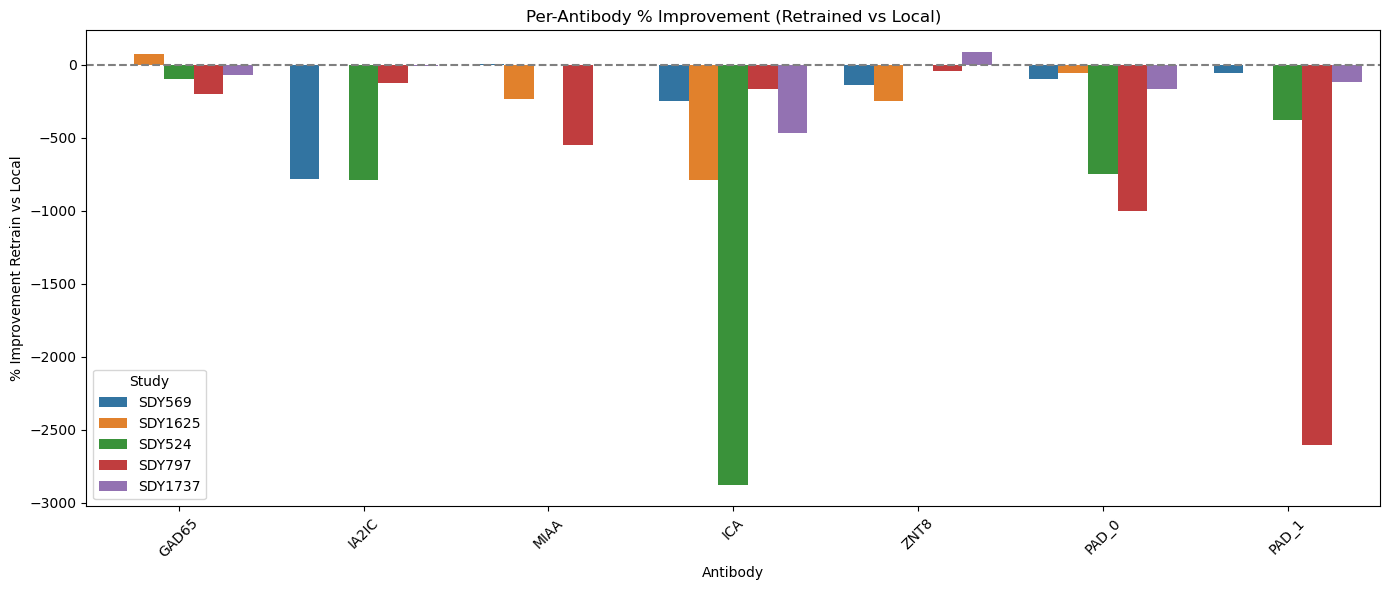

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure % improvement columns are numeric
df_antibody_mse["% Improvement Fed vs Local"] = pd.to_numeric(
    df_antibody_mse["% Improvement Fed vs Local"], errors="coerce"
)
df_antibody_mse["% Improvement Retrain vs Local"] = pd.to_numeric(
    df_antibody_mse["% Improvement Retrain vs Local"], errors="coerce"
)

# Plot: Per-Antibody % Improvement (Federated vs Local)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_antibody_mse,
    x="Antibody",
    y="% Improvement Fed vs Local",
    hue="Study"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Federated vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Per-Antibody % Improvement (Retrain vs Local)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_antibody_mse,
    x="Antibody",
    y="% Improvement Retrain vs Local",
    hue="Study"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Retrained vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
